In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import pandas as pd

np.random.seed(0)
tf.set_random_seed(0)

In [24]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [25]:
n_samples

55000

In [2]:
def xavier_init(fan_in, fan_out, constant=1):
    low = -constant*np.sqrt(6.0/(fan_in + fan_out))
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

In [3]:
class VariationalAutoencoder(object):
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # create the autoencoder network
        self._create_network()
        
        # define loss function based variational upper bound and optimizer
        self._create_loss_optimizer()
        
        # initialize the variables
        init = tf.global_variables_initializer()
        #init = tf.initialize_all_tables()
        
        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _create_network(self):
        # init the network weighs and biases
        network_weights = self._initialize_weights(**self.network_architecture)
        
        # use recognition network to deterimen mean and log variance of Gauss dist in latent space
        self.z_mean, self.z_log_sigma_sq = \
        self._recognition_network(network_weights["weights_recog"],
                                 network_weights["biases_recog"])
        
        # draw one sample z from gaussian
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, .5, dtype=tf.float32)
        
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                       tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        
        # Use generator to determine mean of bernoulli distr of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                   network_weights["biases_gener"])
    
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2,
                           n_hidden_gener_1, n_hidden_gener_2,
                           n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))
        }
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        }
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))
        }
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))
        }
        return all_weights
    
    def _recognition_network(self, weights, biases):
        # generate probabilistic encoder to map inputs onto a normal distribution in latent space
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']),
                                          biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                          biases['b2']))
        
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                       biases['out_mean'])
        
        z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_log_sigma']),
                               biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (maps points in latent space to 
        # bernoulli distri in data space
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']),
                                          biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                          biases['b2']))
        
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']),
                                              biases['out_mean']))
        return x_reconstr_mean
    
    def _create_loss_optimizer(self):
        reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                                      + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                                      1)
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                          - tf.square(self.z_mean)
                                          - tf.exp(self.z_log_sigma_sq), 1)
        
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                 feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """Generate data by sampling from latent space."""
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
            
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})


In [4]:
def train(network_architecture, learning_rate=0.001, batch_size=100,
         training_epochs=10, display_step=5):
    
    vae = VariationalAutoencoder(network_architecture,
                                learning_rate=learning_rate,
                                batch_size=batch_size)
    # Training cycle
    for epoch in tqdm(range(training_epochs), leave=True):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        for i in (range(total_batch)):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            cost = vae.partial_fit(batch_xs)
            avg_cost += cost / n_samples * batch_size
    return vae


In [72]:
xs, ys = mnist.train.next_batch(100)

In [73]:
xs.shape

(100, 784)

In [70]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=100)

100%|██████████| 100/100 [02:48<00:00,  1.71s/it]


In [70]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

NameError: name 'vae' is not defined

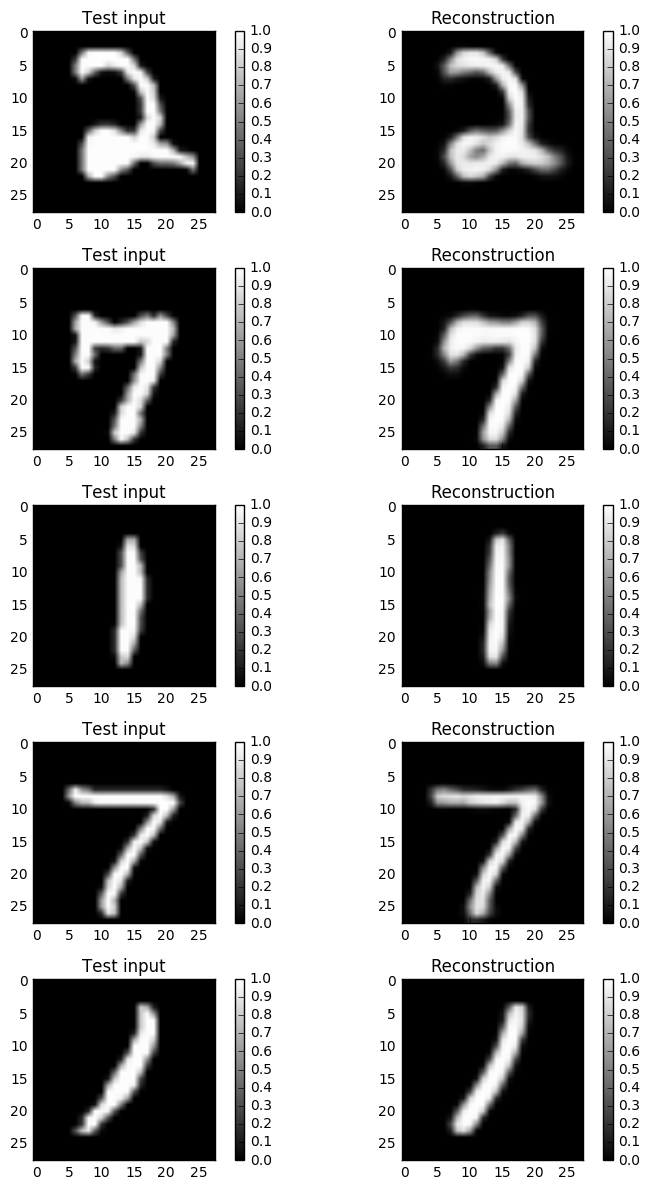

In [73]:
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

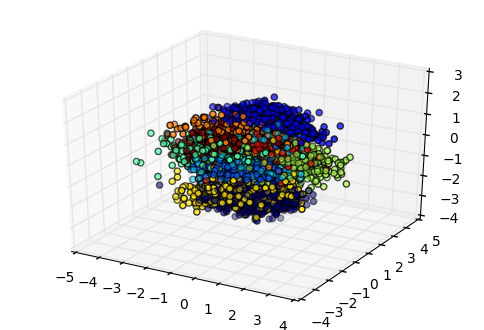

In [53]:
x_s, y_s = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_s)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_mu[:, 0], z_mu[:, 1], z_mu[:, 2], c=np.argmax(y_s, 1))

In [5]:
import pickle
data_files = ['/mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-10/spectral_pandas.pickle',
              '/mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-11/spectral_pandas.pickle',
              '/mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-12/spectral_pandas.pickle',
              '/mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-13/spectral_pandas.pickle',
              '/mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-14/spectral_pandas.pickle',
              '/mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-09/spectral_pandas.pickle',
              '/mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-07/spectral_pandas.pickle'
              ]
all_df = []

for data_file in data_files:
    with open(data_file, 'r') as pickle_file:
        all_df.append(pickle.load(pickle_file))

df = pd.concat(all_df)

In [6]:
df.shape

(306, 5)

In [7]:
all_spectra = np.array(df['spectral'].as_matrix())
#plt.plot(all_spectra[1]);

In [11]:
len(all_spectra[0])

50

In [14]:
all_spectra_array = np.concatenate([np.array(s) for s in all_spectra], axis=1)

In [15]:
all_spectra_array.shape

(50, 42103)

In [52]:
df.shape[0]

71

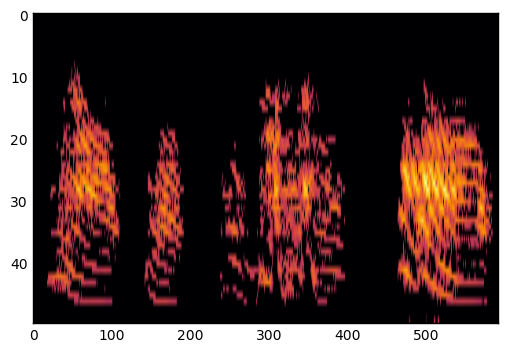

In [57]:
bout_spectr = np.array(all_spectra[60])
plt.imshow((bout_spectr[::-1]), cmap='inferno', aspect='auto')

In [54]:
bout_spectr.shape

(50, 593)

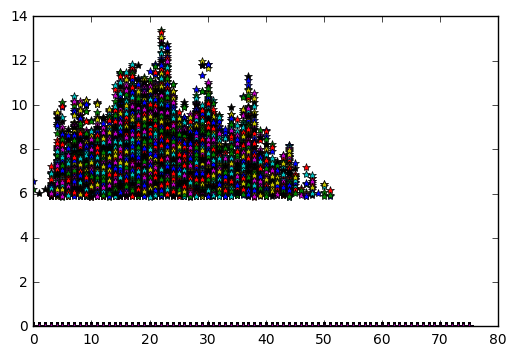

In [30]:
plt.plot(df['spectral'][0], '*');

In [12]:
# a batch generator using pandas
class PdBatcher(object):
    def __init__(self, data_frame, x_field=None, y_field=None, train_fraction=0.1):
        self.data_frame = data_frame.sample(frac=1)
        self.train_fraction = train_fraction
        self.x_field = x_field
        self.y_field = y_field
        
        self.max_pow = np.amax(data_frame['spectral'].max())
        self._split()
        self._make_train_array()
        #self._make_test_array()
        
    def _split(self):
        random_frac = int(self.data_frame.shape[0] * self.train_fraction)
        self.train_frame = self.data_frame[random_frac:]
        self.test_frame = self.data_frame[:random_frac]
        
    def _make_train_array(self):
        all_spectra = np.array(self.train_frame['spectral'].as_matrix())
        self.all_train_array = np.concatenate([np.array(s) for s in all_spectra], axis=1)/self.max_pow
        self.all_label_array = np.arange(self.all_train_array.shape[1])%len(all_spectra[0][1])
        
    def _make_test_array(self):
        all_spectra = np.array(self.test_frame['spectral'].as_matrix())
        self.all_test_array = np.stack([np.array(s) for s in all_spectra], axis=0)/self.max_pow
        
    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[1], n)
        return [self.all_train_array[:, idx].T, self.all_label_array[idx]]
    
    def test_batch(self, n_mot):
        idx = np.random.randint(0, self.all_test_array.shape[0], n_mot)
        test_array_batch = self.all_test_array[idx]
        return test_array_batch

pdb = PdBatcher(df)

x, y = pdb.train_batch(593)

In [14]:
y.shape

(593,)

In [21]:
asp = np.array(pdb.test_frame['spectral'].as_matrix())
aspt = ([np.array(s).shape for s in asp])

In [26]:
n_samples = pdb.all_train_array.shape[-1]
n_samples

190128

In [92]:
def train_spec(network_architecture, learning_rate=0.001, batch_size=100,
         training_epochs=10):
    
    vae = VariationalAutoencoder(network_architecture,
                                learning_rate=learning_rate,
                                batch_size=batch_size)
    # Training cycle
    for epoch in tqdm(range(training_epochs), leave=True):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        for i in (range(total_batch)):
            batch_xs, _ = pdb.train_batch(batch_size)
            cost = vae.partial_fit(batch_xs)
            avg_cost += cost / n_samples * batch_size
    return vae

network_architecture = \
    dict(n_hidden_recog_1=50, # 1st layer encoder neurons
         n_hidden_recog_2=50, # 2nd layer encoder neurons
         n_hidden_gener_1=50, # 1st layer decoder neurons
         n_hidden_gener_2=50, # 2nd layer decoder neurons
         n_input=50, # MNIST data input (img shape: 28*28)
         n_z=5)  # dimensionality of latent space



vae = train_spec(network_architecture, training_epochs=500, batch_size=b_size)

100%|██████████| 500/500 [14:12<00:00,  1.75s/it]


In [27]:
x_sample = pdb.train_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

NameError: name 'vae' is not defined

In [103]:
x_sample.shape

(100, 50)

In [111]:
x_test.T.shape

(593, 50)

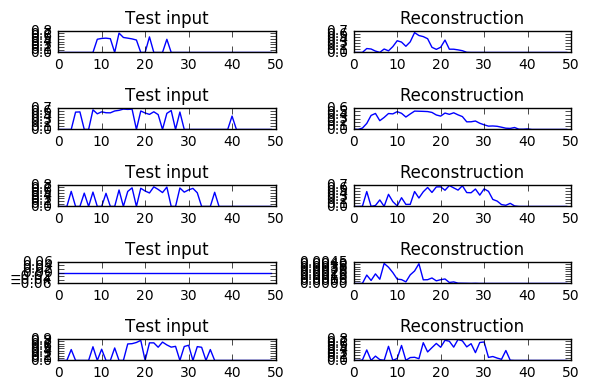

In [94]:
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.plot(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.plot(x_reconstruct[i])
    plt.title("Reconstruction")
plt.tight_layout()

In [113]:
x_test = pdb.test_batch(2)[0]
x_reconstruct = vae.reconstruct(x_test.T[:100,:])

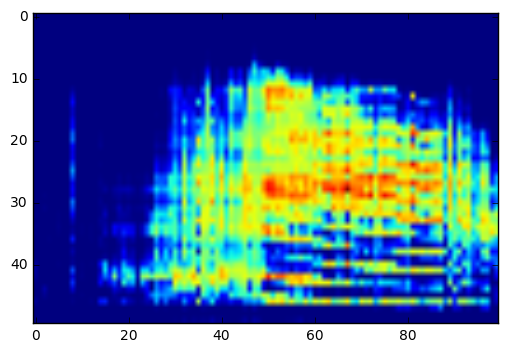

In [115]:
plt.imshow(x_reconstruct.T[::-1], aspect='auto')

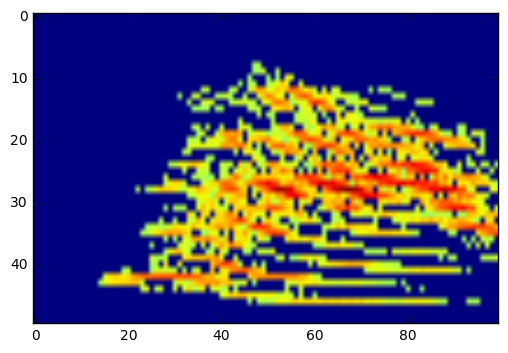

In [121]:
plt.imshow(x_test[:,:100][::-1], aspect='auto')